In [1]:
%load_ext autoreload
%autoreload 2


## Setup

In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim


In [3]:
jax.__version__, _galsim.__version__


('0.4.19', '2.5.0')

In [4]:
jax.devices()


[cuda(id=0), cuda(id=1), cuda(id=2), cuda(id=3)]

In [5]:
jax.config.update("jax_default_device", jax.devices()[0])


In [6]:
import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put


In [7]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random


/pscratch/sd/i/imendoza/miniconda3/envs/jax2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from tqdm import tqdm


In [9]:
import bpd
from bpd.chains import run_chains
from bpd.draw import add_noise


## Fit

### Setup

In [10]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e4
NOISE = 1

# galaxy
HLR = 0.9
TRUE_FLUX = 1e5
TRUE_LOG_FLUX = np.log10(TRUE_FLUX)


In [11]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=HLR)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    im = gal_conv.array
    return im


In [12]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
@jax.vmap
def draw_gal(lf):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=HLR)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    return image.array


## Test

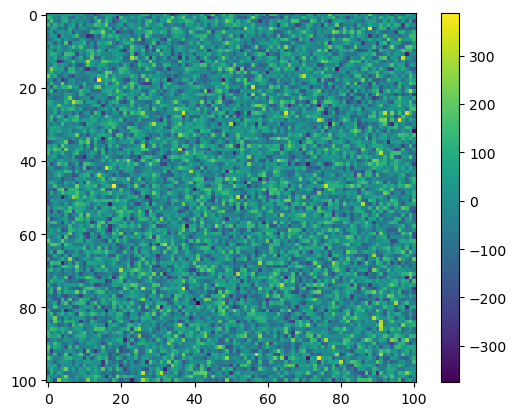

In [18]:
# check error is very small on true thingies
lf = jnp.array([TRUE_LOG_FLUX]) 
im, _ = add_noise(_draw_gal(), bg=BACKGROUND)
arr = im[0]- draw_gal(lf)[0]
plt.imshow(arr)
plt.colorbar()


### Run

In [27]:
def prob_model(data=None):
    batch_dim, _, _ = data.shape
    with numpyro.plate("b", batch_dim, dim=-1):
        lf = numpyro.sample('lf', dist.Uniform(3, 6))
        im = draw_gal(lf)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=data)


In [32]:
TRUE_IMAGE = _draw_gal()
nuts_kernel = NUTS(prob_model)
rng_key = random.PRNGKey(42)

data, noise = add_noise(TRUE_IMAGE, n=1, bg=BACKGROUND)
data.shape


### Diagnostics

In [407]:
lf = samples['lf']


In [409]:
lf.shape


(1000, 1000)

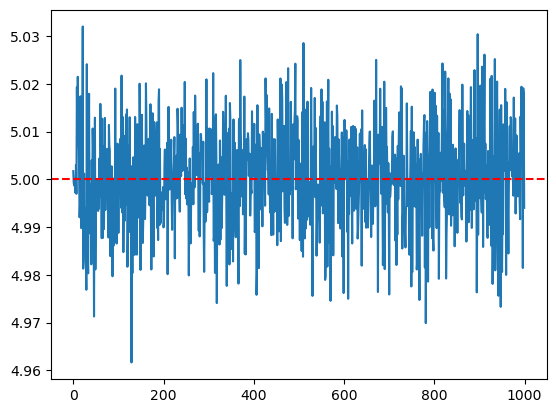

In [411]:
plt.plot(lf[0, :])
plt.axhline(5,color='r', ls='--') 


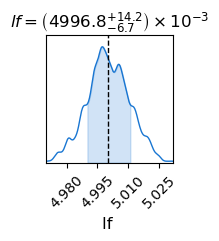

In [369]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain({'lf':lf[0,:]}, name='posterior')
fig = c.plotter.plot(truth={'lf':5})


In [396]:
print_summary_from_samples(samples)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     lf[0]      5.00      0.01      5.00      4.98      5.02    949.86      1.46



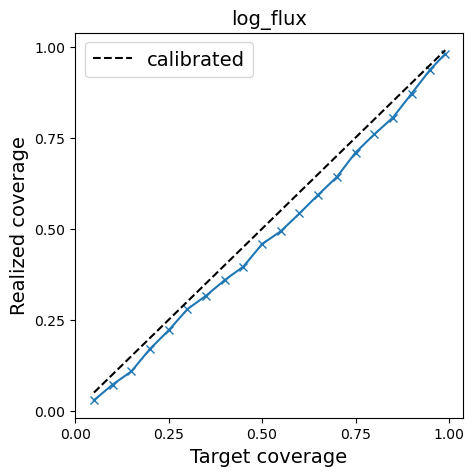

In [272]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
get_pc_fig(ax, lf, 5, param_name='log_flux')

# interpretation: 
# if blue curve is below dotted line, that means that points fall in confidence region less than they should. 
# => predicted uncertainty is smaller than it should be (otherwise more points would be covered) => model is overconfident
